In [27]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/readme/examples/LodeSTAR/08.measure_mass_simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [28]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

In [29]:
import numpy as np
import matplotlib.pyplot as plt

crop_size = 40
padding = 32
wavelength = 633e-9 
pixel_size = 114e-9
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

particle = dt.MieSphere(
    radius=lambda: 228e-9,
    refractive_index=lambda: 1.58,
    z=lambda: 0,
    position=(crop_size / 2,) * 2,
    L=100,
)

optics = dt.Brightfield(
    NA=1.3,
    magnification=1,
    wavelength=633e-9,
    resolution=2*1.14e-7,
    illumination=dt.Gaussian(sigma=0.005) >> dt.Gaussian(sigma=0.005j), 
    return_field=True, 
    output_region=(0, 0, 40, 40)
)

imaged_particle = optics(particle) 
training_data = (imaged_particle >> dt.Real()) & (imaged_particle >> dt.Imag())
training_data = training_data >> dt.Merge(lambda: lambda x: np.concatenate( [np.array(_x) for _x in x], axis=-1 ))

In [30]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randint(-4, 4),
    rescale=lambda: 10**np.random.uniform(-2, 2)
)

group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.Rescale(args.rescale) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.005)
)

equivariance = (
     dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >>dt.models.lodestar.TranslationalEquivariance(args.translate)
    
    >> dt.models.lodestar.Equivariance(1, lambda arg: np.log(arg), arg = args.rescale, indexes=2)
)




<AxesSubplot:>

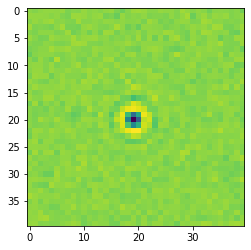

In [31]:
val = training_data.update()()
training_set = dt.Value(lambda: np.array(val)) 
(training_set >> group).update().plot()

In [32]:
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    3,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)



In [33]:

with generator:
    model = dt.models.LodeSTAR(input_shape=(None, None, 2), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=50, steps_per_epoch=100)


Generating 201 / 200 samples before starting training
Epoch 1/50
100/100 [==============================] - 3s 11ms/step - total_loss: 2.7148 - consistency_loss: 1.5351
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - total_loss: 2.6751 - consistency_loss: 1.4401
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - total_loss: 2.4524 - consistency_loss: 1.2219
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - total_loss: 1.3793 - consistency_loss: 0.6563: 0s - total_loss: 1.843
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - total_loss: 0.7814 - consistency_loss: 0.3688
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - total_loss: 0.5045 - consistency_loss: 0.2026
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - total_loss: 0.3404 - consistency_loss: 0.1149
Epoch 8/50
100/100 [==============================] - 1s 9ms/step - total_loss: 0.2732 - consistency_loss: 0.0791
Epoch 9/5

In [53]:
import itertools
import scipy
grid_x = 8
radius_range = np.linspace(130e-9, 300e-9, grid_x)
refractive_index_range = np.linspace(1.4, 1.7, grid_x)

num_samples = 10

data_dict = {}

for radius, refractive_index in itertools.product(radius_range, refractive_index_range):

    for _ in range(num_samples):
        image = training_data.update()(radius=radius, refractive_index=refractive_index, z=np.random.uniform(-1, 1))

        if (radius, refractive_index) not in data_dict:
            data_dict[(radius, refractive_index)] = []

        data_dict[(radius, refractive_index)].append(image)  

In [90]:
error_dict = {}
for key, value in data_dict.items():
    preds = model.predict_and_pool(np.array(value))
    error_dict[key] = np.exp(preds[:, 2])

RI, R = np.meshgrid(refractive_index_range, radius_range)

GT = R**3 * (RI ** 2 - 1.33 ** 2) / (RI ** 2 + 1.33 ** 2 * 2)
GT = GT[..., np.newaxis]

In [91]:
Z = np.reshape(np.array(list(error_dict.values())), (grid_x, grid_x, -1))

norm_f = GT[4, 4] / np.mean(Z[4, 4]) 
Z = Z * norm_f

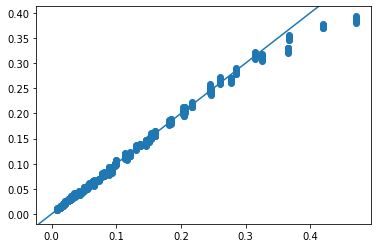

In [92]:
plt.scatter(np.repeat(GT, num_samples, -1).flatten() * 1e20, Z.flatten() * 1e20)
plt.axline((0, 0), slope=1)
plt.show()


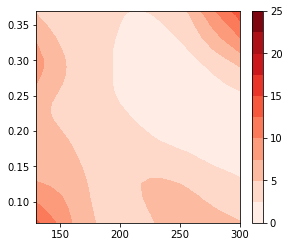

In [93]:
import scipy
plt.figure(figsize=(3.5 * 1.3, 3 * 1.3))
err = np.abs(Z - GT).mean(-1) / np.abs(GT).mean(-1) * 100
err = scipy.ndimage.zoom(err, 3)
err = dt.GaussianBlur(2)(err)

plt.contourf(
    scipy.ndimage.zoom(R, 3) * 1e9,
    scipy.ndimage.zoom(RI - 1.33, 3),
    err.squeeze(),
    cmap="Reds",
    levels=np.linspace(0, 25, 11)
)
plt.colorbar()